In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os

import tensorflow as tf
import keras
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten,MaxPooling2D
from keras.models import Model, Sequential
from keras.regularizers import l2
from keras import backend as K
from keras.optimizers import SGD,Adam
from keras.losses import binary_crossentropy
from keras.utils import plot_model

### Data Preprocessing

In [2]:
base_dir = r'fruits-360/Training/'
train_test_split = 0.7
no_of_files_in_each_class = 10

#Read all the folders in the directory
folder_list = os.listdir(base_dir)
print( len(folder_list), "categories found in the dataset")

#Declare training array
cat_list = []
x = []
y = []
y_label = 0

#Using just 5 images per category
for folder_name in folder_list:
    files_list = os.listdir(os.path.join(base_dir, folder_name))
    temp=[]
    for file_name in files_list[:no_of_files_in_each_class]:
        temp.append(len(x))
        x.append(np.asarray(Image.open(os.path.join(base_dir, folder_name, file_name)).convert('RGB').resize((100, 100))))
        y.append(y_label)
    y_label+=1
    cat_list.append(temp)

cat_list = np.asarray(cat_list)
x = np.asarray(x)/255.0
y = np.asarray(y)
print('X, Y shape',x.shape, y.shape, cat_list.shape)        

131 categories found in the dataset
X, Y shape (1310, 100, 100, 3) (1310,) (131, 10)


### Train test split

In [3]:
train_size = int(len(folder_list)*train_test_split)
test_size = len(folder_list) - train_size
print(train_size, 'classes for training and', test_size, ' classes for testing')

train_files = train_size * no_of_files_in_each_class

#Training Split
x_train = x[:train_files]
y_train = y[:train_files]
cat_train = cat_list[:train_size]

#Validation Split
x_val = x[train_files:]
y_val = y[train_files:]
cat_test = cat_list[train_size:]

print('X&Y shape of training data :',x_train.shape, 'and', y_train.shape, cat_train.shape)
print('X&Y shape of testing data :' , x_val.shape, 'and', y_val.shape, cat_test.shape)

91 classes for training and 40  classes for testing
X&Y shape of training data : (910, 100, 100, 3) and (910,) (91, 10)
X&Y shape of testing data : (400, 100, 100, 3) and (400,) (40, 10)


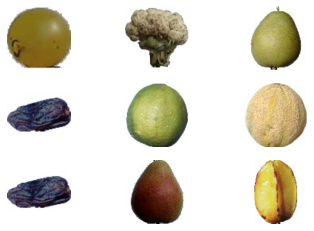

In [5]:
#Plotting Images
for i in range(0,9):
    plt.subplot(3, 3, i+1)
    plt.axis('off')
    plt.imshow(x_train[np.random.randint(0, x_train.shape[0]-1)])
plt.show()

### Generating Batch

In [6]:
def get_batch(batch_size=64, call_type='train'):
    
    temp_x = None
    temp_cat_list = None
    start=None
    end=None
    batch_x=[]
    
    if call_type == 'train':
        temp_x = x_train
        temp_cat_list = cat_train
        start=0
        end = train_size
    else:
        temp_x = x_val
        temp_cat_list = cat_test
        start = train_size+1
        end = len(folder_list)-1
        
    batch_y = np.zeros(batch_size)
    batch_y[int(batch_size/2):] = 1
    np.random.shuffle(batch_y)
    
    class_list = np.random.randint(start, end, batch_size) 
    batch_x.append(np.zeros((batch_size, 100, 100, 3)))
    batch_x.append(np.zeros((batch_size, 100, 100, 3)))

    for i in range(0, batch_size):
        batch_x[0][i] = temp_x[np.random.choice(temp_cat_list[class_list[i]])]  
        #If train_y has 0 pick from the same class, else pick from any other class
        if batch_y[i]==0:
            batch_x[1][i] = temp_x[np.random.choice(temp_cat_list[class_list[i]])]

        else:
            temp_list = np.append(temp_cat_list[:class_list[i]].flatten(), temp_cat_list[class_list[i]+1:].flatten())
            batch_x[1][i] = temp_x[np.random.choice(temp_list)]
            
    return(batch_x, batch_y)

### Siamese Network

In [7]:
#Building a sequential model

def initialize_weights(shape, dtype=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

def initialize_bias(shape, dtype=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

input_shape=(100, 100, 3)
left_input = Input(input_shape)
right_input = Input(input_shape)

W_init = keras.initializers.RandomNormal(mean = 0.0, stddev = 1e-2)
b_init = keras.initializers.RandomNormal(mean = 0.5, stddev = 1e-2)

model = Sequential()
model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
model.add(MaxPooling2D())  
model.add(Conv2D(128, (7,7), activation='relu',kernel_initializer=initialize_weights,bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
model.add(MaxPooling2D())
model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
model.add(MaxPooling2D())
model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
model.add(Flatten())
model.add(Dense(4096, activation='sigmoid',kernel_regularizer=l2(1e-3),kernel_initializer=initialize_weights,bias_initializer=initialize_bias))

encoded_l = model(left_input)
encoded_r = model(right_input)

# L1_distance = lambda x: K.abs(x[0] - x[1])
# print(type(L1_distance))
# both = merge([encoded_l, encoded_r], mode=L1_distance, output_shape = lambda x:x[0])
subtracted = keras.layers.Subtract()([encoded_l, encoded_r])
prediction = Dense(1, activation='sigmoid', bias_initializer=b_init)(subtracted)
siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)

optimizer= Adam(learning_rate=0.0006)
siamese_net.compile(loss='binary_crossentropy', optimizer=optimizer)

optimizer = Adam(lr = 0.00006)
model.compile(loss="binary_crossentropy",optimizer=optimizer)

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 39, 39, 128)       401536    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 19, 19, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 128)       262272    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 5, 256)         5

### N-way One shot learning

In [8]:
def nway_one_shot(model, n_way, n_val):
    
    temp_x = x_val
    temp_cat_list = cat_test
    batch_x=[]
    x_0_choice=[]
    n_correct = 0
   
    class_list = np.random.randint(train_size+1, len(folder_list)-1, n_val)

    for i in class_list:  
        j = np.random.choice(cat_list[i])
        temp=[]
        temp.append(np.zeros((n_way, 100, 100, 3)))
        temp.append(np.zeros((n_way, 100, 100, 3)))
        for k in range(0, n_way):
            temp[0][k] = x[j]
            
            if k==0:
                #print(i, k, j, np.random.choice(cat_list[i]))
                temp[1][k] = x[np.random.choice(cat_list[i])]
            else:
                #print(i, k, j, np.random.choice(np.append(cat_list[:i].flatten(), cat_list[i+1:].flatten())))
                temp[1][k] = x[np.random.choice(np.append(cat_list[:i].flatten(), cat_list[i+1:].flatten()))]

        result = siamese_net.predict(temp)
        result = result.flatten().tolist()
        result_index = result.index(min(result))
        if result_index == 0:
            n_correct = n_correct + 1
    print(n_correct, "correctly classified among", n_val)
    accuracy = (n_correct*100)/n_val
    return accuracy
            

In [9]:
nway_one_shot(model, 5, 7)

0 correctly classified among 7


0.0

### Model Training

In [12]:
epochs = 500
n_way = 20
n_val = 100
batch_size = 64

loss_list=[]
accuracy_list=[]
for epoch in range(1,epochs):
    batch_x, batch_y = get_batch(batch_size, call_type="train")
    loss = siamese_net.train_on_batch(batch_x, batch_y)
    loss_list.append((epoch,loss))
    print('Epoch:', epoch, ', Loss:',loss)
    if epoch%50 == 0:
        print("=============================================")
        accuracy = nway_one_shot(model, n_way, n_val)
        accuracy_list.append((epoch, accuracy))
        print('Accuracy as of', epoch, 'epochs:', accuracy)
        print("=============================================")
        if(accuracy>99):
            print("Achieved more than 90% Accuracy")
            #break

Epoch: 1 , Loss: 0.798264741897583
Epoch: 2 , Loss: 0.7926499247550964
Epoch: 3 , Loss: 0.7872596383094788
Epoch: 4 , Loss: 0.7828242778778076
Epoch: 5 , Loss: 0.778009295463562
Epoch: 6 , Loss: 0.7750588059425354
Epoch: 7 , Loss: 0.7717035412788391
Epoch: 8 , Loss: 0.7687811851501465
Epoch: 9 , Loss: 0.7657926678657532
Epoch: 10 , Loss: 0.7631424069404602
Epoch: 11 , Loss: 0.7607848644256592
Epoch: 12 , Loss: 0.7589033842086792
Epoch: 13 , Loss: 0.7562257051467896
Epoch: 14 , Loss: 0.7546859383583069
Epoch: 15 , Loss: 0.7523105144500732
Epoch: 16 , Loss: 0.7513347864151001
Epoch: 17 , Loss: 0.7487659454345703
Epoch: 18 , Loss: 0.7481197118759155
Epoch: 19 , Loss: 0.7469381093978882
Epoch: 20 , Loss: 0.7455263733863831
Epoch: 21 , Loss: 0.7444779276847839
Epoch: 22 , Loss: 0.7437745332717896
Epoch: 23 , Loss: 0.7441242933273315
Epoch: 24 , Loss: 0.7425882816314697
Epoch: 25 , Loss: 0.7417188882827759
Epoch: 26 , Loss: 0.7414807081222534
Epoch: 27 , Loss: 0.7405288815498352
Epoch: 28 , 

Epoch: 204 , Loss: 0.7114619612693787
Epoch: 205 , Loss: 0.7113524079322815
Epoch: 206 , Loss: 0.711262047290802
Epoch: 207 , Loss: 0.7112236618995667
Epoch: 208 , Loss: 0.7110868096351624
Epoch: 209 , Loss: 0.7110637426376343
Epoch: 210 , Loss: 0.7110453844070435
Epoch: 211 , Loss: 0.7109525203704834
Epoch: 212 , Loss: 0.710874617099762
Epoch: 213 , Loss: 0.7108352780342102
Epoch: 214 , Loss: 0.7107526659965515
Epoch: 215 , Loss: 0.7106867432594299
Epoch: 216 , Loss: 0.7106237411499023
Epoch: 217 , Loss: 0.7105801105499268
Epoch: 218 , Loss: 0.710534393787384
Epoch: 219 , Loss: 0.710456371307373
Epoch: 220 , Loss: 0.7103912234306335
Epoch: 221 , Loss: 0.7103282809257507
Epoch: 222 , Loss: 0.7102764844894409
Epoch: 223 , Loss: 0.7102343440055847
Epoch: 224 , Loss: 0.7101485133171082
Epoch: 225 , Loss: 0.7100964188575745
Epoch: 226 , Loss: 0.7100265622138977
Epoch: 227 , Loss: 0.7099760174751282
Epoch: 228 , Loss: 0.7099164128303528
Epoch: 229 , Loss: 0.709862232208252
Epoch: 230 , Loss

Epoch: 404 , Loss: 0.7025019526481628
Epoch: 405 , Loss: 0.7024706602096558
Epoch: 406 , Loss: 0.7024394869804382
Epoch: 407 , Loss: 0.7024081349372864
Epoch: 408 , Loss: 0.7023770213127136
Epoch: 409 , Loss: 0.7023460865020752
Epoch: 410 , Loss: 0.702315092086792
Epoch: 411 , Loss: 0.7022843360900879
Epoch: 412 , Loss: 0.7022535800933838
Epoch: 413 , Loss: 0.7022228240966797
Epoch: 414 , Loss: 0.7021923065185547
Epoch: 415 , Loss: 0.7021618485450745
Epoch: 416 , Loss: 0.7021313905715942
Epoch: 417 , Loss: 0.7021011114120483
Epoch: 418 , Loss: 0.7020708918571472
Epoch: 419 , Loss: 0.7020407915115356
Epoch: 420 , Loss: 0.7020106315612793
Epoch: 421 , Loss: 0.7019806504249573
Epoch: 422 , Loss: 0.7019509673118591
Epoch: 423 , Loss: 0.7019211053848267
Epoch: 424 , Loss: 0.7018913626670837
Epoch: 425 , Loss: 0.7018618583679199
Epoch: 426 , Loss: 0.7018323540687561
Epoch: 427 , Loss: 0.7018029689788818
Epoch: 428 , Loss: 0.7017735838890076
Epoch: 429 , Loss: 0.7017443180084229
Epoch: 430 , 

In [15]:
print(accuracy_list)

[(50, 4.0), (100, 4.0), (150, 8.0), (200, 8.0), (250, 7.0), (300, 12.0), (350, 8.0), (400, 22.0), (450, 100.0)]
